In [1]:
#练习8： 异常检测与推荐系统

In [2]:
##异常检测 （非监督学习）

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns

import scipy.io as sio
from scipy import stats

import sys
sys.path.append('..')

from ml import anomaly

from sklearn.cross_validation import train_test_split

In [4]:
mat = sio.loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['__globals__', 'Xval', 'X', '__header__', '__version__', 'yval'])

In [5]:
X_data = mat.get('X')


In [6]:
#分为训练和测试数据
X_train,X_test, y_train, y_test = train_test_split(mat.get('Xval'),mat.get('yval').ravel(), test_size=0.7)

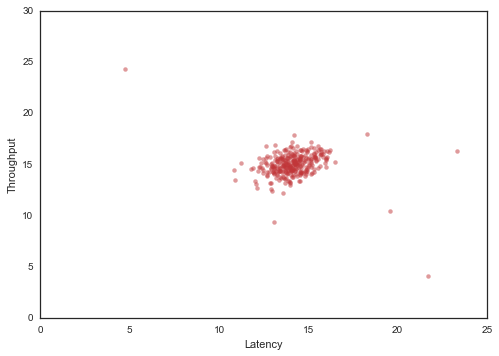

In [7]:
#可视化

sns.set(context="notebook", style="white", palette=sns.color_palette("RdBu"))
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X_data, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           scatter_kws={"s":20,
                        "alpha":0.5})

In [8]:
#平均值
X_mean = X_data.mean(axis=0)
print(X_mean)

#估算协方差
cov = np.cov(X_data.T)
print(cov)

[ 14.11222578  14.99771051]
[[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


In [9]:
np.dstack(np.mgrid[0:3,0:3])

array([[[0, 0],
        [0, 1],
        [0, 2]],

       [[1, 0],
        [1, 1],
        [1, 2]],

       [[2, 0],
        [2, 1],
        [2, 2]]])

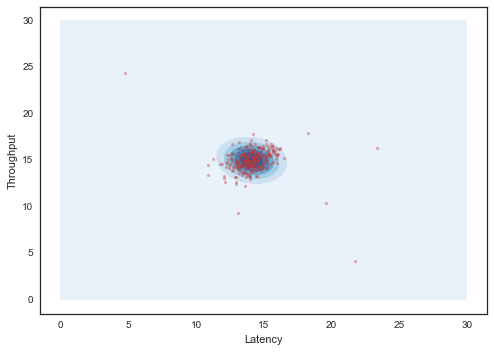

In [10]:
#多元高斯分布模型

multi_normal = stats.multivariate_normal(X_mean, cov)


x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()


ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')


sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X_data, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           ax=ax,
           scatter_kws={"s":10,
                        "alpha":0.4})

F1的算法

<img style="float: left;" src="../img/f1_score.png">

In [11]:
e, fs = anomaly.select_threshold(X_data, X_train,y_train)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 2.7023073618235194e-05
Best F-score on validation data: 0.8


In [12]:
multi_normal, y_pred = anomaly.predict(X_data, X_train, e, X_test, y_test)

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       209
          1       1.00      0.67      0.80         6

avg / total       0.99      0.99      0.99       215



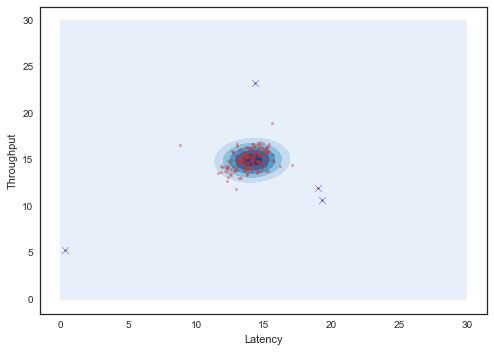

In [13]:
# construct test DataFrame
data = pd.DataFrame(X_test, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

# create a grid for graphing
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original Xval points
sns.regplot('Latency', 'Throughput',
            data=data,
            fit_reg=False,
            ax=ax,
            scatter_kws={"s":10,
                         "alpha":0.4})

# mark the predicted anamoly of CV data. We should have a test set for this...
anamoly_data = data[data['y_pred']==1]
ax.scatter(anamoly_data['Latency'], anamoly_data['Throughput'], marker='x', s=50)

In [14]:
mat = sio.loadmat('./data/ex8data2.mat')

In [15]:
X = mat.get('X')
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

In [16]:
e, fs = anomaly.select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 1.74667432759803e-19
Best F-score on validation data: 0.7499999999999999


In [17]:
multi_normal, y_pred = anomaly.predict(X, Xval, e, Xtest, ytest)

             precision    recall  f1-score   support

          0       0.93      1.00      0.97        43
          1       1.00      0.57      0.73         7

avg / total       0.94      0.94      0.93        50



In [18]:
print('find {} anamolies'.format(y_pred.sum()))

find 4 anamolies


In [19]:
##推荐系统  基于用户的电影推荐

from ml import  recommender as rcmd


In [20]:
#加载数据

movies_mat = sio.loadmat('./data/ex8_movies.mat')

print(movies_mat.keys())

# Y 电影 和 用户 R 是 用户在某个电影中是否评分 
Y, R = movies_mat.get('Y'), movies_mat.get('R')

Y.shape, R.shape


#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i 


dict_keys(['__header__', '__globals__', '__version__', 'R', 'Y'])


((1682, 943), (1682, 943))

In [21]:
n_movie, n_user = Y.shape

n_feature = 10

In [22]:
param_mat = sio.loadmat('./data/ex8_movieParams.mat')
print(param_mat.keys())

#theta 
theta, X = param_mat.get('Theta'), param_mat.get('X')

theta.shape, X.shape

dict_keys(['__globals__', 'X', 'Theta', '__header__', 'num_features', '__version__', 'num_users', 'num_movies'])


((943, 10), (1682, 10))

# 代价函数
<img style="float: left;" src="../img/rcmd_cost.png">

In [23]:
#小数据量测试 

users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
theta_sub = theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

param_sub = rcmd.serialize(X_sub, theta_sub)

rcmd.cost(param_sub, Y_sub, R_sub, features)

22.224603725685675

In [24]:
# 计算代价 
param = rcmd.serialize(X, theta)

rcmd.cost(rcmd.serialize(X, theta), Y, R, 10) 

27918.64012454421

# gradient
<img style="float: left;" src="../img/rcmd_gradient.png">

In [25]:
X_grad, theta_grad = rcmd.deserialize(rcmd.gradient(param, Y, R, 10),
                                      n_movie, n_user, 10)

<img style="float: left;" src="../img/rcmd_vectorized_grad.png">

In [26]:
assert X_grad.shape == X.shape
assert theta_grad.shape == theta.shape

In [27]:
# regularized cost

rcmd.regularized_cost(param, Y, R, 10, l=1)  # total regularized cost

32520.682450229557

# regularized gradient
<img style="float: left;" src="../img/rcmd_reg_grad.png">

In [28]:
n_movie, n_user = Y.shape

X_grad, theta_grad = rcmd.deserialize(rcmd.regularized_gradient(param, Y, R, 10),
                                                                n_movie, n_user, 10)

assert X_grad.shape == X.shape
assert theta_grad.shape == theta.shape

In [29]:
#解析movie_id.txt

movie_list = []

with open('./data/movie_ids.txt', encoding='latin-1') as f:
    for line in f:
        tokens = line.strip().split(' ')
        movie_list.append(' '.join(tokens[1:]))

movie_list = np.array(movie_list)

In [30]:

ratings = np.zeros(1682)

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

In [31]:
##准备数据

Y, R = movies_mat.get('Y'), movies_mat.get('R')

Y = np.insert(Y, 0, ratings, axis=1)
Y.shape

(1682, 944)

In [32]:
R = np.insert(R, 0, ratings != 0, axis=1)
R.shape

(1682, 944)

In [33]:
n_features = 50
n_movie, n_user = Y.shape
l = 10

In [34]:
X = np.random.standard_normal((n_movie, n_features))
theta = np.random.standard_normal((n_user, n_features))

X.shape, theta.shape

((1682, 50), (944, 50))

In [35]:
param = rcmd.serialize(X, theta)

In [36]:
Y_norm = Y - Y.mean()
Y_norm.mean()

4.6862111343939375e-17

In [37]:
##训练
import scipy.optimize as opt

In [38]:
res = opt.minimize(fun=rcmd.regularized_cost,
                   x0=param,
                   args=(Y_norm, R, n_features, l),
                   method='TNC',
                   jac=rcmd.regularized_gradient)

In [39]:
res

     fun: 64721.497815075141
     jac: array([  1.00880791e-05,  -7.81101492e-07,  -1.73679901e-06, ...,
         6.62309420e-07,  -8.64922452e-07,  -5.74048722e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 2442
     nit: 78
  status: 1
 success: True
       x: array([-0.03862355, -0.24487032,  0.38665165, ...,  0.13673055,
       -0.54222834, -0.69394197])

In [40]:
X_trained, theta_trained = rcmd.deserialize(res.x, n_movie, n_user, n_features)
X_trained.shape, theta_trained.shape

((1682, 50), (944, 50))

In [41]:
#预测
prediction = X_trained @ theta_trained.T

In [42]:
my_preds = prediction[:, 0] + Y.mean()

In [43]:
idx = np.argsort(my_preds)[::-1]
idx.shape

(1682,)

In [44]:
my_preds[idx][:10]

array([ 4.12535104,  4.04413692,  3.99324354,  3.91902979,  3.81690931,
        3.81556246,  3.76602464,  3.76322789,  3.75904956,  3.75077295])

In [45]:
#打印top10

for m in movie_list[idx][:10]:
    print(m)

Titanic (1997)
Star Wars (1977)
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Raiders of the Lost Ark (1981)
Braveheart (1995)
Return of the Jedi (1983)
Usual Suspects, The (1995)
Godfather, The (1972)
Schindler's List (1993)


In [ ]:
#练习8 完